Answer all questions and submit them either as an IPython notebook, LaTeX document, or Markdown document. Each question is worth 25 points.

This homework is due Friday, September 22, 2017.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy
from sklearn.linear_model import LinearRegression

## Question 1

The data below provides counts of a flour beetle (Tribolium confusum) population at various points in time:

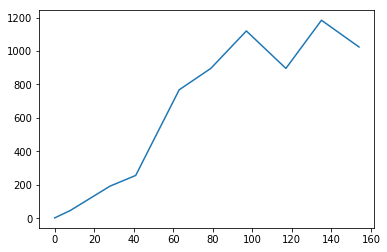

In [2]:
days = 0,8,28,41,63,79,97,117,135,154
beetles = 2,47,192,256,768,896,1120,896,1184,1024

plt.plot(days, beetles)

An elementary model for population growth is the logistic model:

$$\frac{dN}{dt} = rN\left(1 - \frac{N}{K}\right)$$

where $N$ is population size, $t$ is time, $r$ is a growth rate parameter, and $K$ is a parameter that represents the population carrying capacity of the environment. The solution to this differential equation is given by: 

$$N_t = f(t) = \frac{KN_0}{N_0 + (K - N_0)\exp(-rt)}$$

where $N_t$ denotes the population size at time $t$. 

1. Fit the logistic growth model to the flour beetle data using optimization to minimize the sum of squared errors between model predictions and observed counts.

2. In many population modeling applications, an assumption of lognormality is adopted. The simplest assumption would be that the $\log(N_t)$ are independent and normally distributed with mean $\log[f(t)]$ and variance $\sigma^2$. Find the MLEs under this assumption, and provide estimates of standard errors and correlation between them.

Question 1.1
We can rewrite the logistic model to:

$$\frac{d(log\frac{p}{1-p})}{dt} = r, \text{where } p = \frac{N}{K}$$

So we can $logistic(p)=rt+logistic(p_0), p = \frac{N}{K} \text{and } p_0 = \frac{N_0}{K}$. Finally the solution comes as:

$$N_t = f(t) = \frac{KN_0}{N_0 + (K - N_0)\exp(-rt)}$$

Fit the logistic growth model to the flour beetle data using optimization to minimize the sum of squared errors between model predictions and observed counts.

The cost function $J$ can be expressed as:
$$J = \frac{1}{2m} (\hat{N_t} - N_t)^2 \sim (\hat{N_t} - N_t)^2$$


The first model using least square error gives K = 1033.515, r = 0.118


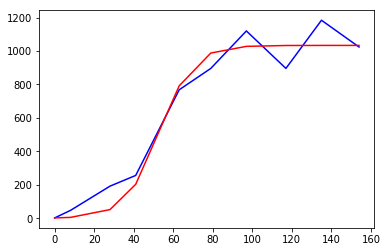

In [3]:
# code for question 1.1
def costfunc(theta):
    K = theta[0]
    r = theta[1]
    N_0 = 2
    t = days
    N_t = beetles
    N_t_hat = 1.0*N_0*K/(N_0+(K-N_0)*np.exp(-r*t))
    return np.sum((N_t_hat - N_t)**2)

days = np.array(days)
beetles = np.array(beetles)
# optimization
from scipy.optimize import minimize
# intialized guess

theta = [500, 0.5]
res = minimize(costfunc, theta, method='Nelder-Mead', tol = 1e-6)
K = res.x[0]
r = res.x[1]
print("The first model using least square error gives K = %.3f, r = %.3f" % (K, r))
N_0 = 2
model1 = 1.0*N_0*K/(N_0+(K-N_0)*np.exp(-r*days))

# plot vs the original
plt.plot(days, beetles, c = 'b')
plt.plot(days, model1, c = 'r')

Question 1.2 The assumptions:

$$ log(N_t) \sim N(f(t), \sigma^2)$$
Get the log-likelihood for each data point based on the normal model and add them up to minimize. Since we need to provide estimates of standard errors and correlation between them, let's bootstrap the 10-point dataset for 1000 times and obtain $K_i$ and $r_i$ in each loop. Finally, calculate each strandard error and their correlation.

In [4]:
# code for question 1.2
from scipy.stats import norm

def loglikelihood(theta):
    K = theta[0]
    r = theta[1]
    var = theta[2]
    t = new_days
    x = new_beetles
    N_0 = 2
    # will use minimize, multiply by -1 instead
    return -1.0*np.sum(norm.logpdf(np.log(x),loc=np.log(1.0*N_0*K/(N_0+(K-N_0)*np.exp(-r*t))),scale=var))

# intialize at each loop
n = 1000
K_para = np.zeros(n)
r_para = np.zeros(n)
var_para = np.zeros(n)
new_days = np.zeros(days.shape)
new_beetles = np.zeros(beetles.shape)

for i in range(n):
    index = np.random.choice(len(days), len(days))
    new_days = np.take(days, index)
    new_beetles = np.take(beetles, index)
    theta = [500, 0.5, np.var(np.log(new_beetles))]
    res = minimize(loglikelihood, theta, method='Nelder-Mead', tol = 1e-6)
    K_para[i] = res.x[0]
    r_para[i] = res.x[1]
    var_para[i] = res.x[2]

print("The standard error of K is %.3f." % np.var(K_para))
print("The standard error of r is %.3f." % np.var(r_para))
print("The standard error of var is %.3f." % np.var(var_para))
print("The correlation between K and r is %.3f." % np.corrcoef(K_para, r_para)[0,1])
print("The correlation between r and var is %.3f." % np.corrcoef(r_para, var_para)[0,1])
print("The correlation between var and K is %.3f." % np.corrcoef(var_para, K_para)[0,1])

/anaconda/envs/myenv/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1691: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/anaconda/envs/myenv/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1691: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/anaconda/envs/myenv/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:876: RuntimeWarning: invalid value encountered in greater_equal
  return (self.a <= x) & (x <= self.b)
/anaconda/envs/myenv/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:876: RuntimeWarning: invalid value encountered in less_equal
  return (self.a <= x) & (x <= self.b)


The standard error of K is 34356.441.
The standard error of r is 0.017.
The standard error of var is 0.041.
The correlation between K and r is -0.538.
The correlation between r and var is 0.504.
The correlation between var and K is -0.856.


## Question 2

A. Implement simulated annealing for minimizing the AIC for the baseball salary regression problem. Model your algorithm on the example given in class. 
1. Compare the effects of different cooling schedules (different temperatures and different durations at each temperature).  
2. Compare the effect of a proposal distribution that is discrete uniform over 2-neighborhoods versus one that is discrete uniform over 3-neighborhoods.

In [5]:
baseball = pd.read_table('../data/baseball.dat', sep='\s+')
predictors = baseball.copy()
logsalary = predictors.pop('salary').apply(np.log)
nrows, ncols = predictors.shape

aic = lambda g, X, y: len(y) * np.log(sum((g.predict(X) - y)**2)/len(y)) + 2*g.rank_

def annealingfunc(cooling_schedule, neighbors= 1, color = 'r'):
    aic_values = []
    solution_current = solution_best = np.random.binomial(1, 0.5, ncols).astype(bool)
    solution_vars = predictors[predictors.columns[solution_current]]
    g = LinearRegression().fit(X=solution_vars, y=logsalary)
    aic_best = aic(g, solution_vars, logsalary)
    aic_values.append(aic_best)
    for tau in cooling_schedule:

        # Random change # 0f neighborhood
        flips = np.random.choice(ncols, neighbors, replace = False)
        for flip in flips:
            solution_current[flip] = not solution_current[flip] 
        solution_vars = predictors[predictors.columns[solution_current]]
        g = LinearRegression().fit(X=solution_vars, y=logsalary)
        aic_step = aic(g, solution_vars, logsalary)
        alpha = min(1, np.exp((aic_values[-1] - aic_step)/tau))

        if ((aic_step < aic_values[-1]) or (np.random.uniform() < alpha)):
            # Accept proposed solution
            aic_values.append(aic_step)
            if aic_step < aic_best:
                # Replace previous best with this one
                aic_best = aic_step
                solution_best = solution_current.copy()
        else:
            # Revert solution
            solution_current[flip] = not solution_current[flip]
            aic_values.append(aic_values[-1])
    # for comparison, add color argument
    plt.plot(aic_values, color)
    plt.xlim(0, len(aic_values))
    plt.xlabel('Iteration')
    plt.ylabel('AIC')
    print('Best AIC: {0}\nBest solution: {1}\nDiscovered at iteration {2}'.format(aic_best, 
                np.where(solution_best==True),
                np.where(aic_values==aic_best)[0][0]))
    plt.plot(np.where(aic_values==aic_best)[0][0], aic_best, color + 'o')

Best AIC: -418.13976968891296
Best solution: (array([ 1,  2,  5,  7,  9, 11, 12, 13, 14, 15, 22, 24, 25]),)
Discovered at iteration 290
Best AIC: -419.0784458825786
Best solution: (array([ 1,  2,  7,  9, 10, 12, 13, 14, 15, 16, 23, 24, 25]),)
Discovered at iteration 179
Best AIC: -416.9284223954482
Best solution: (array([ 2,  6,  7,  9, 12, 13, 14, 15, 19, 21, 24, 26]),)
Discovered at iteration 277


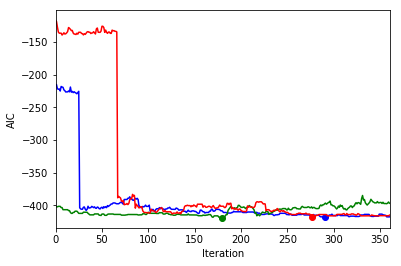

In [6]:
# Compare the effects of different cooling schedules (different temperatures and different durations at each temperature).
tau_start = 10
# in class cases
cooling_schedule = [tau_start]*60 + [tau_start/2]*120 + [tau_start/10]*180
annealingfunc(cooling_schedule, color = 'b')
# flip the sequence
annealingfunc(cooling_schedule[::-1], color = 'g')
# try equal length
cooling_schedule = [tau_start]*120 + [tau_start/2]*120 + [tau_start/10]*120
annealingfunc(cooling_schedule, color = 'r')

Flipping the cooling schedule make the AIC values increase in last few iterations. So starting with high-value temperature is crucial. Probably choose smaller values as the iteration goes on. I prefer the original cooling schedule in our example case (blue curve).

/anaconda/envs/myenv/lib/python3.6/site-packages/ipykernel/__main__.py:24: RuntimeWarning: overflow encountered in exp


Best AIC: -410.3813926974779
Best solution: (array([ 1,  2,  3,  6,  8,  9, 10, 12, 13, 14, 17, 23, 26]),)
Discovered at iteration 105
Best AIC: -418.60301983804766
Best solution: (array([ 2,  5,  7,  9, 11, 12, 13, 19, 20, 21]),)
Discovered at iteration 174
Best AIC: -418.6118886471737
Best solution: (array([ 2,  5,  7,  9, 12, 13, 19, 20, 21, 23, 24]),)
Discovered at iteration 143


/anaconda/envs/myenv/lib/python3.6/site-packages/ipykernel/__main__.py:24: RuntimeWarning: overflow encountered in double_scalars
/anaconda/envs/myenv/lib/python3.6/site-packages/ipykernel/__main__.py:24: RuntimeWarning: divide by zero encountered in double_scalars


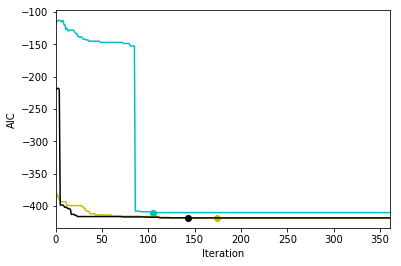

In [7]:
# try different ratio factors 0.9, 0.5, 0.1
cooling_schedule = [tau_start*0.9**i for i in range(360)]
annealingfunc(cooling_schedule, color = 'c')
cooling_schedule = [tau_start*0.5**i for i in range(360)]
annealingfunc(cooling_schedule, color = 'y')
cooling_schedule = [tau_start*0.1**i for i in range(360)]
annealingfunc(cooling_schedule, color = 'k')

It seems that we obtain the best and minimum AIC value for 0.9 and 0.5 ratio factor earlier than 0.1. I pefer use 0.9 or 0.8 because it makes the cooling schedule more smoothly than 0.5 and 0.1.

Best AIC: -406.03507309331917
Best solution: (array([ 1,  4,  5,  7,  8,  9, 11, 12, 13, 15, 16, 19, 20, 21, 24]),)
Discovered at iteration 95
Best AIC: -410.2889349507507
Best solution: (array([ 0,  2,  5,  6,  7,  9, 12, 13, 14, 15, 18, 19, 20, 22, 23, 24, 25,
       26]),)
Discovered at iteration 91


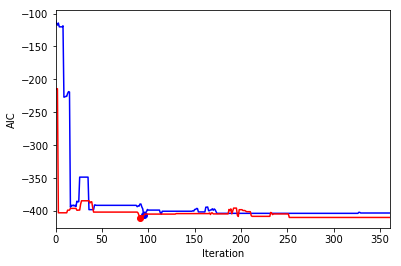

In [8]:
# Compare the effect of a proposal distribution that is discrete uniform 
# over 2-neighborhoods versus one that is discrete uniform over 3-neighborhoods.
cooling_schedule = [tau_start*i/360 for i in range(360, 0, -1)]
annealingfunc(cooling_schedule, neighbors =2, color = 'b')
annealingfunc(cooling_schedule, neighbors =3, color = 'r')

Choosing 3-neighborhoods seems better than 2-neighborhoods.

B. Implement a genetic algorithm for minimizing the AIC for the baseball salary regression problem. Model your algorithm on Example 3.5. 
1. Compare the effects of using different mutation rates.  
2. Compare the effects of using different generation sizes.  
3. Instead of the selection mechanism used in the class example, try using independent selection of both parents with probabilities proportional to their fitness.

In [9]:
def calculate_fitness(aic_values):
    P = len(aic_values)
    aic_rank = (-aic_values).argsort().argsort()+1.
    return 2.*aic_rank/(P*(P+1.))

def geneticfunc(mutation_rate, pop_size, iterations, double_selection = False, color = 'b'):
    aic_best = []
    best_solution = []
    aic_history = []
    # Initialize genotype
    current_gen = np.random.binomial(1, 0.5, pop_size*ncols).reshape((pop_size, ncols))
    for i in range(iterations):

        # Get phenotype
        current_phe = [predictors[predictors.columns[g.astype(bool)]] for g in current_gen]
        # Calculate AIC
        current_aic = np.array([aic(LinearRegression().fit(X=x, y=logsalary), x, logsalary) for x in current_phe])
        # Get lowest AIC
        aic_best.append(current_aic[np.argmin(current_aic)])
        best_solution.append(current_gen[np.argmin(current_aic)])

        # Calculate fitness according to AIC rank
        fitness = calculate_fitness(current_aic)

        # Choose first parents according to fitness
        moms = np.random.choice(range(pop_size), size=int(pop_size/2), p=fitness)
        if not double_selection:
            # Choose second parents randomly
            # in the example
            dads = np.random.choice(range(pop_size), size=int(pop_size/2))
        else:
            # Choose second parents according to fitness
            dads = np.random.choice(range(pop_size), size=int(pop_size/2), p=fitness)

        next_gen = []
        for x,y in zip(current_gen[moms], current_gen[dads]):
            # Crossover
            cross = np.random.randint(0, ncols)
            child1 = np.r_[x[:cross], y[cross:]]
            child2 = np.r_[y[:cross], x[cross:]]
            # Mutate
            m1 = np.random.binomial(1, mutation_rate, size=ncols).astype(bool)
            child1[m1] = abs(child1[m1]-1)
            m2 = np.random.binomial(1, mutation_rate, size=ncols)
            child2[m2] = abs(child1[m2]-1)
            next_gen += [child1, child2]

        # Increment generation
        current_gen = np.array(next_gen)
        # Store AIC values
        aic_history.append(current_aic)
    
    plt.plot(aic_best, color)
    plt.xlim(0, iterations)
    plt.xlabel('Iteration')
    plt.ylabel('AIC')
    print("The best and minimum AIC is " +str(min(aic_best)))

The best and minimum AIC is -414.949406131
The best and minimum AIC is -415.201389724
The best and minimum AIC is -417.415685538
The best and minimum AIC is -418.603019838
The best and minimum AIC is -417.498199813


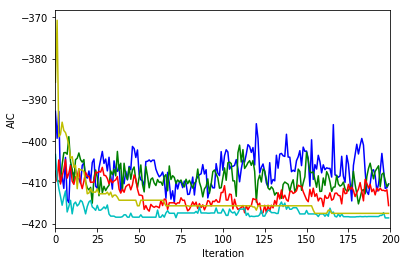

In [10]:
# Compare the effects of using different mutation rates.
mutation_rates = [0.2, 0.1, 0.05, 0.02, 0.005]
colors = ['b', 'g', 'r', 'c', 'y']
for i in range(len(colors)):
    geneticfunc(mutation_rates[i], pop_size = 20, iterations = 200, color = colors[i])

It seems that 0.02 and 0.005 are better than other mutation_rates.

The best and minimum AIC is -417.793734375
The best and minimum AIC is -420.947211437
The best and minimum AIC is -420.081805182
The best and minimum AIC is -420.947211437
The best and minimum AIC is -418.611888647


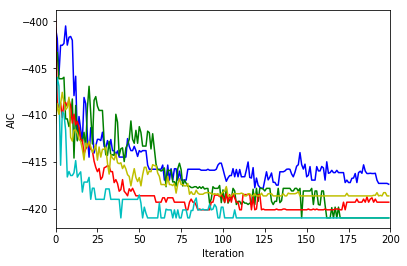

In [11]:
# Compare the effects of using different generation sizes.
generation_sizes = [10, 20, 30, 40, 50]
colors = ['b', 'g', 'r', 'c', 'y']
for i in range(len(colors)):
    geneticfunc(mutation_rate = 0.02, pop_size = generation_sizes[i], iterations = 200, color = colors[i])

As the generation size grows (for example, 40, 50), we obtained the best and minimum AIC. Considering the computational cost, 20 is okay.

The best and minimum AIC is -418.554286599
The best and minimum AIC is -420.947211437


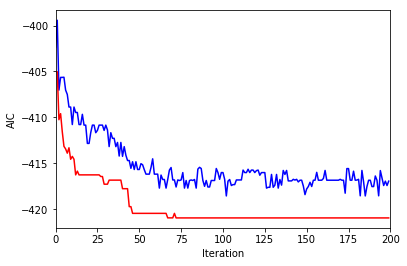

In [12]:
# Instead of the selection mechanism used in the class example, 
# try using independent selection of both parents with probabilities proportional to their fitness.
geneticfunc(mutation_rate = 0.02, pop_size = 20, iterations = 200, double_selection = False, color = 'b')
geneticfunc(mutation_rate = 0.02, pop_size = 20, iterations = 200, double_selection = True, color = 'r')

Use 0.02 as mutation rate, 20 as generation size. The blue curve represents our original case in the example while we choose both parents according to the fitness and show the AIC tendency in the red curve. Without comparing the AIC values (very close), the blue curve seems more gradually decreasing to the minimum while the red curve is fast dropping down. Maybe I will prefer the blue curve.

## Question 3

Use the combinatorial optimization method of your choice to obtain a solution to the traveling salesman problem for the Brazilian cities described in the lecture notes, using minimum total distance as the criterion. Use the the first city listed in the dataset as "home" (*i.e.* the trip must start and end there). I will award 5 bonus points to the best solution!

In [13]:
def parse_latlon(x):
    d, m, s = map(float, x.split(':'))
    ms = m/60. + s/3600.
    if d<0:
        return d - ms
    return d + ms

cities =  pd.read_csv('../data/brasil_capitals.txt', \
                      names=['city','lat','lon'])[['lat','lon']].applymap(parse_latlon)
cities = np.array(cities)

def distance(route):
    '''
    route is a non-replace index of cities.
    its sequence represents the traveling salesman route.
    return: distance, route
    '''
    loop = None 
    loop = np.append(route, route[0])
    res = 0
    for i in range(len(loop)-1):
        res += np.sqrt((cities[loop[i+1]][0] - cities[loop[i]][0])**2 + (cities[loop[i+1]][1] - cities[loop[i]][1])**2)
    return res

def annealingfunc(route, cooling_schedule, iteration_schedule):
    cur_distance = distance(route)
    # the simulating annealing run
    for cooling_step in range(len(cooling_schedule)):
        for iteration in range(iteration_schedule[cooling_step]):
            new_route = route.copy()
            # try to set up 2 as neighbors, another paramerters
            # found just do swap 2 index is good enough
            # flip_index = np.random.choice(len(route), size = neighbors, replace = False)
            [i, j] = np.random.choice(len(route), size = 2, replace = False)
            new_route[i], new_route[j] = new_route[j], new_route[i]
            new_distance = distance(new_route)
            # find alpha
            alpha = min(1, np.exp((cur_distance-new_distance)/cooling_schedule[cooling_step]) )
            # Accept or Reject?
            if (new_distance < cur_distance) or (np.random.uniform() < alpha):
                route = new_route
                cur_distance = new_distance
#     print("Distance:{0: .3f}, Route:{1}".format(cur_distance, route))
    return cur_distance, route 

# try different hyperparameters
tau_start_list = [10, 20, 40]
steps_list = [30, 40, 100]
factor_list = [0.9, 0.8, 0.7]
# neighbors_list = [2,4,6]
distance_list = []
route_list = []

for tau_start in tau_start_list:
    for steps in steps_list:
        for factor in factor_list:
            # for neighbors in neighbors_list:
                # initialize
            cooling_schedule = [tau_start*factor**i for i in range(steps)]
            iteration_schedule = [10]*int(steps/5) + [20]*int(steps/5) + [50]*int(steps/5) \
            + [300]*int(steps/5) + [500]*int(steps/5)
            route = np.random.permutation(range(len(cities)))
            temp_distance = None
            temp_route = None
            temp_distance, temp_route = annealingfunc(route, cooling_schedule, iteration_schedule)   
            distance_list.append(temp_distance)
            route_list.append(temp_route)

# get the index of the smallest value in running results
ind = distance_list.index(min(distance_list))
distance_so_far = distance_list[ind]
route_so_far = route_list[ind]
print(distance_so_far)
print(route_so_far)

/anaconda/envs/myenv/lib/python3.6/site-packages/ipykernel/__main__.py:37: RuntimeWarning: overflow encountered in exp


137.788793139
[25 23 17 20 15 12 10  4  0  1  2  3  5  7  8  9 11 14  6 13 16 18 19 21 22
 24]


129.322174637
133.037436728
132.145440379
131.868214622
139.71363406
137.540336706
152.5902868
133.037436728
132.342343311
142.240764513
148.092123143
128.556322472
146.744997984
134.176706903
132.387210198
140.517327991
138.957878414
135.630264372
137.788793139
141.792204794
130.762249722
138.766548966
128.391416996
133.950451141
126.017354151
127.392735852
142.058471444
141.757833765
142.634260268
145.044962435
134.561249489
126.017354151
134.134457426
132.387210198
127.95373971
145.457773535
133.043897568
131.23107785
130.762249722
127.392735852
148.279140835
132.340685167
133.037436728
155.097098427
137.132105768
134.920447565
134.217340713
134.696052064
142.414521135
133.493175098


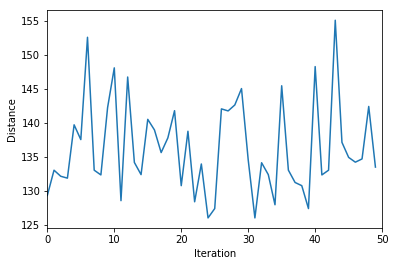

In [14]:
# after I got a better result, I will use the best I got from last chunk
# initilize this again, see what is best from here
route = route_so_far
# fix these parameters, good enough to find from a good start
tau_start = 10
steps = 30
factor = 0.9
best_distance_list = []
best_route_list = []

for _ in range(50): 
    # start this current best result, keep 
    # try different hyperparameters
    distance_list = []
    route_list = []
    cooling_schedule = [tau_start*factor**i for i in range(steps)]
    iteration_schedule = [10]*int(steps/5) + [20]*int(steps/5) + [50]*int(steps/5) \
    + [300]*int(steps/5) + [500]*int(steps/5)
    temp_distance = None
    temp_route = None
    temp_distance, temp_route = annealingfunc(route, cooling_schedule, iteration_schedule)   
    distance_list.append(temp_distance)
    route_list.append(temp_route)

    # get the index of the smallest value in this loop and save it into best
    ind = distance_list.index(min(distance_list))
    print(distance_list[ind])
    best_distance_list.append(distance_list[ind])
    best_route_list.append(route_list[ind])


plt.plot(best_distance_list)
plt.xlim(0, len(best_distance_list))    
plt.xlabel('Iteration')
plt.ylabel('Distance')    

From the figure, we can see that it is around the local minimum. Hopefully it is a reasonable good result.

In [15]:
# best result so far
best_route = [2, 3, 6, 5, 7, 8, 9, 11, 14, 13, 16, 17, 18, 19, 21, 22, 23, 24, 25, 20, 15, 12, 10, 4, 0, 1]
zero_index = best_route.index(0)
best_route = best_route[zero_index:] + best_route[:zero_index]
best_distance = distance(best_route)
print("%.3f"%best_distance)
print(best_route)

126.017
[0, 1, 2, 3, 6, 5, 7, 8, 9, 11, 14, 13, 16, 17, 18, 19, 21, 22, 23, 24, 25, 20, 15, 12, 10, 4]


I suppose the genetic algorithm should have better results than the stimulating annealing method. There are a lot of papers discussing it. Here I found a paper: Genetic algorithms for the traveling salesman problem by Jean-Yves Potvin, Annals of Operations Research. There are a lot of crossover operators when passing the gene from parents to the childs. I am not quite sure how to define the fitness in this question. I would like to see the code using the genetic algorithm after grading. 

## Question 4

The `../data/ebola` folder contains summarized reports of Ebola cases from three countries during the recent outbreak of the disease in West Africa. For each country, there are daily reports that contain various information about the outbreak in several cities in each country.

From these data files, use `pandas` to import them and create a single data frame that includes the daily totals of new cases and deaths for each country.

In [16]:
import os
import glob

# three paths
path1 =r'/Users/ruiwang/source/bios_8366/data/ebola/guinea_data'
path2 =r'/Users/ruiwang/source/bios_8366/data/ebola/liberia_data'
path3 =r'/Users/ruiwang/source/bios_8366/data/ebola/sl_data'

# add up
allFiles = []
for path in [path1, path2, path3]:
    allFiles += glob.glob(path + "/*.csv")

ebola = pd.DataFrame()
list_ = []
for file_ in allFiles:
    df = pd.read_csv(file_,index_col=None, header=0)
    list_.append(df)

# fill na as 0 and reindex
ebola = pd.concat(list_).fillna(0).reindex()

# rearrange the columns
col = ebola.columns.tolist()
for x in ['Date', 'Description', 'Totals']:
    col.remove(x)
col = ['Date', 'Description', 'Totals'] + col
ebola = ebola[col]

In [17]:
# check the description about new cases and dealths
ebola.Description.unique()

array(['New cases of suspects', 'New cases of probables',
       'New cases of confirmed', 'Total new cases registered so far',
       'Total cases of suspects', 'Total cases of probables',
       'Total cases of confirmed',
       'Cumulative (confirmed + probable + suspects)',
       'New deaths registered today',
       'New deaths registered today (confirmed)',
       'New deaths registered today (probables)',
       'New deaths registered today (suspects)',
       'Total deaths of suspects', 'Total deaths of probables',
       'Total deaths of confirmed',
       'Total deaths (confirmed + probables + suspects)',
       'Total PEC center today', 'Total PEC center today (confirmed)',
       'Total PEC center today (probables)',
       'Total PEC center today (suspects)',
       'Total of deaths in confirmed cases in CTE',
       'Total of cured in confirmed cases in CTE',
       'Number of male confirmed cases',
       'Number of female confirmed cases',
       'Number of male proba

In [18]:
# many categories, here I apply r'New cases.*confirmed'
mask1 = np.column_stack([ebola['Description'].str.contains(r'New cases.*confirmed', na=False)])
ebola.loc[mask1.any(axis=1)]

,Date,Description,Totals,34 Military Hospital,Beyla,Bo,Bo EMC,Boffa,Bombali,Bomi County,...,Tonkolili,Unnamed: 18,Variable,Western area,Western area combined,Western area rural,Western area urban,Yomou,date,variable
2,2014-08-04,New cases of confirmed,4,0.0,0,0,0.0,0,0,0.0,...,0,0.0,0,0.0,0.0,0,0,0,0,0
2,2014-08-26,New cases of confirmed,10,0.0,0,0,0.0,0,0,0.0,...,0,0.0,0,0.0,0.0,0,0,3,0,0
15,2014-08-26,New cases of confirmed among health workers,0,0.0,0,0,0.0,0,0,0.0,...,0,0.0,0,0.0,0.0,0,0,0,0,0
2,2014-08-27,New cases of confirmed,10,0.0,0,0,0.0,0,0,0.0,...,0,0.0,0,0.0,0.0,0,0,0,0,0
15,2014-08-27,New cases of confirmed among health workers,0,0.0,0,0,0.0,0,0,0.0,...,0,0.0,0,0.0,0.0,0,0,0,0,0
2,2014-08-30,New cases of confirmed,9,0.0,0,0,0.0,0,0,0.0,...,0,0.0,0,0.0,0.0,0,0,0,0,0
15,2014-08-30,New cases of confirmed among health workers,0,0.0,0,0,0.0,0,0,0.0,...,0,0.0,0,0.0,0.0,0,0,0,0,0
2,2014-08-31,New cases of confirmed,29,0.0,0,0,0.0,0,0,0.0,...,0,0.0,0,0.0,0.0,0,0,0,0,0
15,2014-08-31,New cases of confirmed among health workers,0,0.0,0,0,0.0,0,0,0.0,...,0,0.0,0,0.0,0.0,0,0,0,0,0
2,2014-09-02,New cases of confirmed,14,0.0,0,0,0.0,0,0,0.0,...,0,0.0,0,0.0,0.0,0,0,0,0,0


In [19]:
# many categories, here I apply r'New deaths'
mask2 = np.column_stack([ebola['Description'].str.contains(r'New deaths', na=False)])
ebola.loc[mask2.any(axis=1)]

,Date,Description,Totals,34 Military Hospital,Beyla,Bo,Bo EMC,Boffa,Bombali,Bomi County,...,Tonkolili,Unnamed: 18,Variable,Western area,Western area combined,Western area rural,Western area urban,Yomou,date,variable
8,2014-08-04,New deaths registered today,2,0.0,0,0,0.0,0,0,0.0,...,0,0.0,0,0.0,0.0,0,0,0,0,0
9,2014-08-04,New deaths registered today (confirmed),2,0.0,0,0,0.0,0,0,0.0,...,0,0.0,0,0.0,0.0,0,0,0,0,0
10,2014-08-04,New deaths registered today (probables),0,0.0,0,0,0.0,0,0,0.0,...,0,0.0,0,0.0,0.0,0,0,0,0,0
11,2014-08-04,New deaths registered today (suspects),0,0.0,0,0,0.0,0,0,0.0,...,0,0.0,0,0.0,0.0,0,0,0,0,0
9,2014-08-26,New deaths registered,5,0.0,0,0,0.0,0,0,0.0,...,0,0.0,0,0.0,0.0,0,0,3,0,0
17,2014-08-26,New deaths registered among health workers,0,0.0,0,0,0.0,0,0,0.0,...,0,0.0,0,0.0,0.0,0,0,0,0,0
9,2014-08-27,New deaths registered,2,0.0,0,0,0.0,0,0,0.0,...,0,0.0,0,0.0,0.0,0,0,0,0,0
17,2014-08-27,New deaths registered among health workers,0,0.0,0,0,0.0,0,0,0.0,...,0,0.0,0,0.0,0.0,0,0,0,0,0
9,2014-08-30,New deaths registered,5,0.0,0,0,0.0,0,0,0.0,...,0,0.0,0,0.0,0.0,0,0,0,0,0
17,2014-08-30,New deaths registered among health workers,0,0.0,0,0,0.0,0,0,0.0,...,0,0.0,0,0.0,0.0,0,0,0,0,0
